In [1]:
import json
import os 
# Search query in EMDB
# primary_citation_year:[* TO *] AND deposition_date:[2022-01-01T00:00:00Z TO 2023-08-08T00:00:00Z] AND half_map_filename:[* TO *] AND fitted_pdbs:[* TO *] AND average_qscore_value:[0.6 TO *] AND structure_determination_method:"singleparticle" AND sample_type:"protein"

# including low resolution maps (LATEST EMDB SEARCH)
# primary_citation_year:[* TO *] AND deposition_date:[2022-01-01T00:00:00Z TO 2023-08-08T00:00:00Z] AND half_map_filename:[* TO *] AND structure_determination_method:"singleparticle" AND sample_type:"protein" AND resolution:[2.5 TO 8} AND map_size_kb:{* TO 100000] 
search_results_json_file = "/home/abharadwaj1/papers/elife_paper/figure_information/data/emdb_search_results/EMDB_search_results_including_low_res.json"

search_results = json.load(open(search_results_json_file, "r"))

In [20]:
def get_pdb_id(emdb_id):
    extract_results_from_id = lambda x: [i for i in search_results if i['emdb_id'].split("-")[1] == x][0]
    
    emdb_info = extract_results_from_id(emdb_id)
    try:
        pdb_id = emdb_info['crossreferences']['pdb_list']['pdb_reference'][0]['pdb_id']
    except KeyError:
        print("No PDB ID found for EMDB ID: {}".format(emdb_id))
        pdb_id = None
    return pdb_id

In [26]:
# download the fasta sequence from RCSB https://www.rcsb.org/fasta/entry/8b9c
import requests
import os

request_url = "https://www.rcsb.org/fasta/entry/8b9c"
# get 
r = requests.get(request_url)
# write to file
print(r.text)




>8B9C_1|Chain A[auth 2]|DNA replication licensing factor MCM2|Saccharomyces cerevisiae (4932)
MSDNRRRRREEDDSDSENELPPSSPQQHFRGGMNPVSSPIGSPDMINPEGDDNEVDDVPDIDEVEEQMNEVDLMDDNMYEDYAADHNRDRYDPDQVDDREQQELSLSERRRIDAQLNERDRLLRNVAYIDDEDEEQEGAAQLDEMGLPVQRRRRRRQYEDLENSDDDLLSDMDIDPLREELTLESLSNVKANSYSEWITQPNVSRTIARELKSFLLEYTDETGRSVYGARIRTLGEMNSESLEVNYRHLAESKAILALFLAKCPEEMLKIFDLVAMEATELHYPDYARIHSEIHVRISDFPTIYSLRELRESNLSSLVRVTGVVTRRTGVFPQLKYVKFNCLKCGSILGPFFQDSNEEIRISFCTNCKSKGPFRVNGEKTVYRNYQRVTLQEAPGTVPPGRLPRHREVILLADLVDVSKPGEEVEVTGIYKNNYDGNLNAKNGFPVFATIIEANSIKRREGNTANEGEEGLDVFSWTEEEEREFRKISRDRGIIDKIISSMAPSIYGHRDIKTAVACSLFGGVPKNVNGKHSIRGDINVLLLGDPGTAKSQILKYVEKTAHRAVFATGQGASAVGLTASVRKDPITKEWTLEGGALVLADKGVCLIDEFDKMNDQDRTSIHEAMEQQSISISKAGIVTTLQARCSIIAAANPNGGRYNSTLPLAQNVSLTEPILSRFDILCVVRDLVDEEADERLATFVVDSHVRSHPENDEDREGEELKNNGESAIEQGEDEINEQLNARQRRLQRQRKKEEEISPIPQELLMKYIHYARTKIYPKLHQMDMDKVSRVYADLRRESISTGSFPITVRHLESILRIAESFAKMRLSEFVSSYDLDRAIKVVVDSFVDAQKVSVRRQLRRSFAIYTLGH
>8B9C_2|Chain B[auth 3]|DNA replicati

In [27]:
def get_sequence(emdb_id):
    import requests
    pdb_id = get_pdb_id(emdb_id)
    
    fasta_sequence_request_url = "https://www.rcsb.org/fasta/entry/{}".format(pdb_id)
    # get
    r = requests.get(fasta_sequence_request_url)
    fasta_string = r.text
    
    return fasta_string
    


In [28]:
input_folder = "/home/abharadwaj1/papers/elife_paper/figure_information/data/model_angelo_using_new_dataset/locscale_maps"
fasta_sequences_folder = "/home/abharadwaj1/papers/elife_paper/figure_information/data/model_angelo_using_new_dataset/fasta_sequences"
for locscale_filename in os.listdir(input_folder):
    emdb_id = locscale_filename.split("_")[1]
    print(emdb_id)
    sequence = get_sequence(emdb_id)
    # save sequence to fasta file
    fasta_filename = os.path.join(fasta_sequences_folder, emdb_id + ".fasta")
    with open(fasta_filename, "w") as f:
        f.write(">" + emdb_id + "\n")
        f.write(sequence)
    


27258
15948
27429
14427
27539
15037
27634
15205
27750
15589
28153
15617
27754
15631
15803
28536
16036
28649
16376
28666
16491
28827
17225
28953
25834
28962
29291
26331
33481
26419
26477
26563
33571
26618
33810
26867
34653
26923
35274
27242
35402
27256
29779
35691
33062
35761
36451
40283


In [29]:
def extract_protein_dna_rna_fasta_from_fasta(fasta_text, title_prefix):
    '''
    Extracts the protein, dna and rna sequences from a fasta file
    '''
    protein_fasta = ""
    dna_fasta = ""
    rna_fasta = ""
    
    dna_chars = ["A","T","C","G"]
    rna_chars = ["A","U","C","G"]
    num_dna_lines = 0
    num_rna_lines = 0
    num_peptide_lines = 0
    
    for line in fasta_text.split("\n"):
        if line.startswith(">"):
            original_title = line
            continue
            
        # remove empty lines and spaces
        line = line.strip()

        # ignore empty lines
        if len(line) == 0:
            continue
        
        # determine from the line if it is a protein, dna or rna
        # dna: A, T, C, G
        # rna: A, U, C, G
        # protein is everything else


        # if all the characters in the line are in dna_chars then it is dna
        if all([x in dna_chars for x in line]):
            num_dna_lines += 1
            dna_fasta += ">DNA_chain_{}_{}".format(num_dna_lines, title_prefix) + "\n"
            dna_fasta += line + "\n"
        # if all the characters in the line are in rna_chars then it is rna
        elif all([x in rna_chars for x in line]):
            num_rna_lines += 1
            rna_fasta += ">RNA_chain_{}_{}".format(num_rna_lines, title_prefix) + "\n"
            rna_fasta += line + "\n"
        # if it is neither dna nor rna then it is protein
        else:
            num_peptide_lines += 1
            protein_fasta += ">PEPTIDE_chain_{}_{}".format(num_peptide_lines, title_prefix) + "\n"
            protein_fasta += line + "\n"
        
    fasta_results = {
        "protein": protein_fasta,
        "dna": dna_fasta,
        "rna": rna_fasta,
        "num_protein_lines": num_peptide_lines,
        "num_dna_lines": num_dna_lines,
        "num_rna_lines": num_rna_lines
    }

    return fasta_results


In [30]:
for fasta_file in os.listdir(fasta_sequences_folder):
    emdb = fasta_file.split(".")[0]
    fasta_file_path = os.path.join(fasta_sequences_folder, fasta_file)
    fasta_text = open(fasta_file_path, "r").read()
    

    fasta_extract = extract_protein_dna_rna_fasta_from_fasta(fasta_text, emdb)

    if fasta_extract["num_protein_lines"] == 0:
        print("No protein lines found for {}".format(emdb))
        continue

    # Write the fasta files
    if fasta_extract["num_dna_lines"] > 0:
        dna_fasta_file = os.path.join(fasta_sequences_folder, f"{emdb}_dna.fasta")
        open(dna_fasta_file, "w").write(fasta_extract["dna"])
    else:
        print("No DNA lines found for {}".format(emdb))
    
    if fasta_extract["num_rna_lines"] > 0:
        rna_fasta_file = os.path.join(fasta_sequences_folder, f"{emdb}_rna.fasta")
        open(rna_fasta_file, "w").write(fasta_extract["rna"])
    else:
        print("No RNA lines found for {}".format(emdb))
    
    protein_fasta_file = os.path.join(fasta_sequences_folder, f"{emdb}_protein.fasta")
    open(protein_fasta_file, "w").write(fasta_extract["protein"])

No RNA lines found for 27258
No DNA lines found for 15948
No RNA lines found for 15948
No DNA lines found for 27429
No RNA lines found for 27429
No DNA lines found for 14427
No RNA lines found for 14427
No DNA lines found for 27539
No RNA lines found for 27539
No DNA lines found for 15037
No RNA lines found for 15037
No DNA lines found for 27634
No RNA lines found for 27634
No DNA lines found for 15205
No RNA lines found for 15205
No DNA lines found for 27750
No RNA lines found for 27750
No DNA lines found for 15589
No RNA lines found for 15589
No DNA lines found for 28153
No RNA lines found for 28153
No DNA lines found for 15617
No RNA lines found for 15617
No DNA lines found for 27754
No RNA lines found for 27754
No DNA lines found for 15631
No RNA lines found for 15631
No DNA lines found for 15803
No RNA lines found for 15803
No DNA lines found for 28536
No RNA lines found for 28536
No DNA lines found for 16036
No DNA lines found for 28649
No RNA lines found for 28649
No DNA lines f

In [3]:
def check_if_same_sequence(results):
    same_sequence = True
    sequence_first = results[0]['sample']['macromolecule_list']['macromolecule'][0]['sequence']
    for result in results[1:]:
        sequence = result['sample']['macromolecule_list']['macromolecule'][0]['sequence']
        if sequence != sequence_first:
            same_sequence = False
            break
    return same_sequence

In [4]:
def check_if_result_is_unique(result1, list_of_results):
    for result2 in list_of_results:
        same_sequence = check_if_same_sequence([result1, result2])
        if same_sequence:
            return False # same sequence found
    return True # no same sequence found

In [5]:
get_pdb_from_result = lambda result1: result1['crossreferences']['pdb_list']['pdb_reference'][0]['pdb_id']


In [6]:
def get_symmetry(result):
    final_reconstruction = result['structure_determination_list']['structure_determination'][0]['image_processing'][0]['final_reconstruction']
    if "applied_symmetry" in final_reconstruction.keys():
        return final_reconstruction['applied_symmetry']['point_group']
    else:
        return "C1"


In [7]:
def get_resolution(result):
    final_reconstruction = result['structure_determination_list']['structure_determination'][0]['image_processing'][0]['final_reconstruction']
    return float(final_reconstruction['resolution']['valueOf_'])

In [14]:
unique_results = []
unique_emdb_ids = []
emdb_config = {}
emdb_ids_list = []
unique_emdb_info = {}
for result1 in search_results:
    list_of_results = [x for x in search_results if x != result1]
    unique_result = check_if_result_is_unique(result1, list_of_results)
    if unique_result:
        emdb_id = result1['emdb_id'].split("-")[1]
        try:
            symmetry = get_symmetry(result1)
            resolution = get_resolution(result1)
            emdb_config[emdb_id] = {'symmetry': symmetry, 'resolution': resolution}
            unique_emdb_ids.append((result1['emdb_id'], get_pdb_from_result(result1)))
            unique_emdb_info[emdb_id] = {'symmetry': symmetry, 'resolution': resolution}
        except:
            continue

print("Number of unique results: {}".format(len(unique_emdb_info)))

Number of unique results: 397


<AxesSubplot:ylabel='Count'>

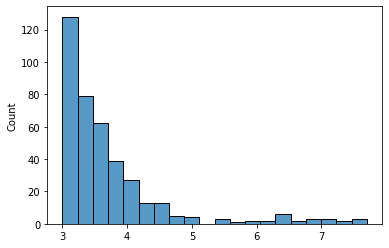

In [18]:
# plot histogram of resolutions
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
unique_resolutions = [unique_emdb_info[emdb_id]['resolution'] for emdb_id in unique_emdb_info]
sns.histplot(unique_resolutions, bins=20)


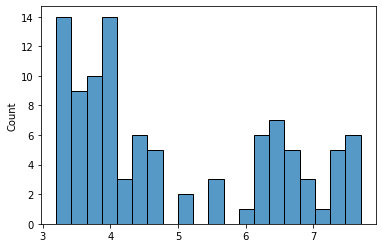

In [20]:
# sample 100 emdb ids such that the distribution of resolutions is uniform
import random
import numpy as np

def get_emdb_ids_with_uniform_resolution_distribution(unique_emdb_info, num_samples):
    unique_resolutions = [unique_emdb_info[emdb_id]['resolution'] for emdb_id in unique_emdb_info]
    unique_resolutions = np.array(unique_resolutions)
    unique_resolutions_norm = (unique_resolutions - unique_resolutions.min())/(unique_resolutions.max() - unique_resolutions.min())
    emdb_ids = list(unique_emdb_info.keys())
    emdb_ids_uniform = random.choices(emdb_ids, weights=unique_resolutions_norm, k=num_samples)
    resolutions_uniform = [unique_emdb_info[emdb_id]['resolution'] for emdb_id in emdb_ids_uniform]
    sns.histplot(resolutions_uniform, bins=20)
    return emdb_ids_uniform

emdb_ids_uniform = get_emdb_ids_with_uniform_resolution_distribution(unique_emdb_info, 100)

In [49]:
# dump to json file
output_file_path = "/home/abharadwaj1/papers/elife_paper/figure_information/data/emdb_search_results/emdb_id_list_uniform_res.json"
with open(output_file_path, 'w') as f:
    json.dump(emdb_ids_uniform, f, indent=4)

In [50]:
print(get_symmetry(search_results[0]), get_resolution(search_results[0]))

D3 2.4
